**Краткая суть**

Необходимо обучить модель предсказывать уйдет ли клиент из банка или нет

**Описание**

Из Банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
Нужно построить модель, которая будет прогнозировать, уйдёт ли клиент из банка в ближайшее время или нет. У нас есть данные о поведении клиентов и расторжении договоров с банком.
Нужно построить модель с предельно большим значением F1-меры.


**Критерии оценки модели**

* Значение метрики F1 на тестовой выборке должно быть не меньше 0.59

**План выполнения проекта**

1. Загрузите и подготовьте данные.
2. Обучить разные модели.
3. Сделать выводы.

## Откроем файл с данными и изучим общую информацию

### Импортируем нужные библиотеки

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import plotly.express as px
import itertools
from tqdm import tqdm
import time


from sklearn.model_selection import GridSearchCV

import sweetviz as sv

from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, 
                            accuracy_score, 
                            f1_score, 
                            r2_score, 
                            classification_report, 
                            mean_absolute_error, 
                            roc_auc_score,
                            roc_curve  
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

### Загрузим файл и посмотрим на него

In [7]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('/file_for_projects/Churn.csv')

In [2]:
df.head(10)

<font size = 2>

<div class="alert alert-info">
<b> Признаки:</b>
</div>

RowNumber — индекс строки в данных

CustomerId — уникальный идентификатор клиента
    
Surname — фамилия

CreditScore — кредитный рейтинг

Geography — страна проживания

Gender — пол

Age — возраст

Tenure — сколько лет человек является клиентом банка

Balance — баланс на счёте

NumOfProducts — количество продуктов банка, используемых клиентом

HasCrCard — наличие кредитной карты

IsActiveMember — активность клиента

EstimatedSalary — предполагаемая зарплата

<div class="alert alert-info">
<b> Целевой признак:</b>
</div>
    
Exited — факт ухода клиента
 
</font> 

In [1]:
df.info()

### Посмотрим на корреляцию в таблице 

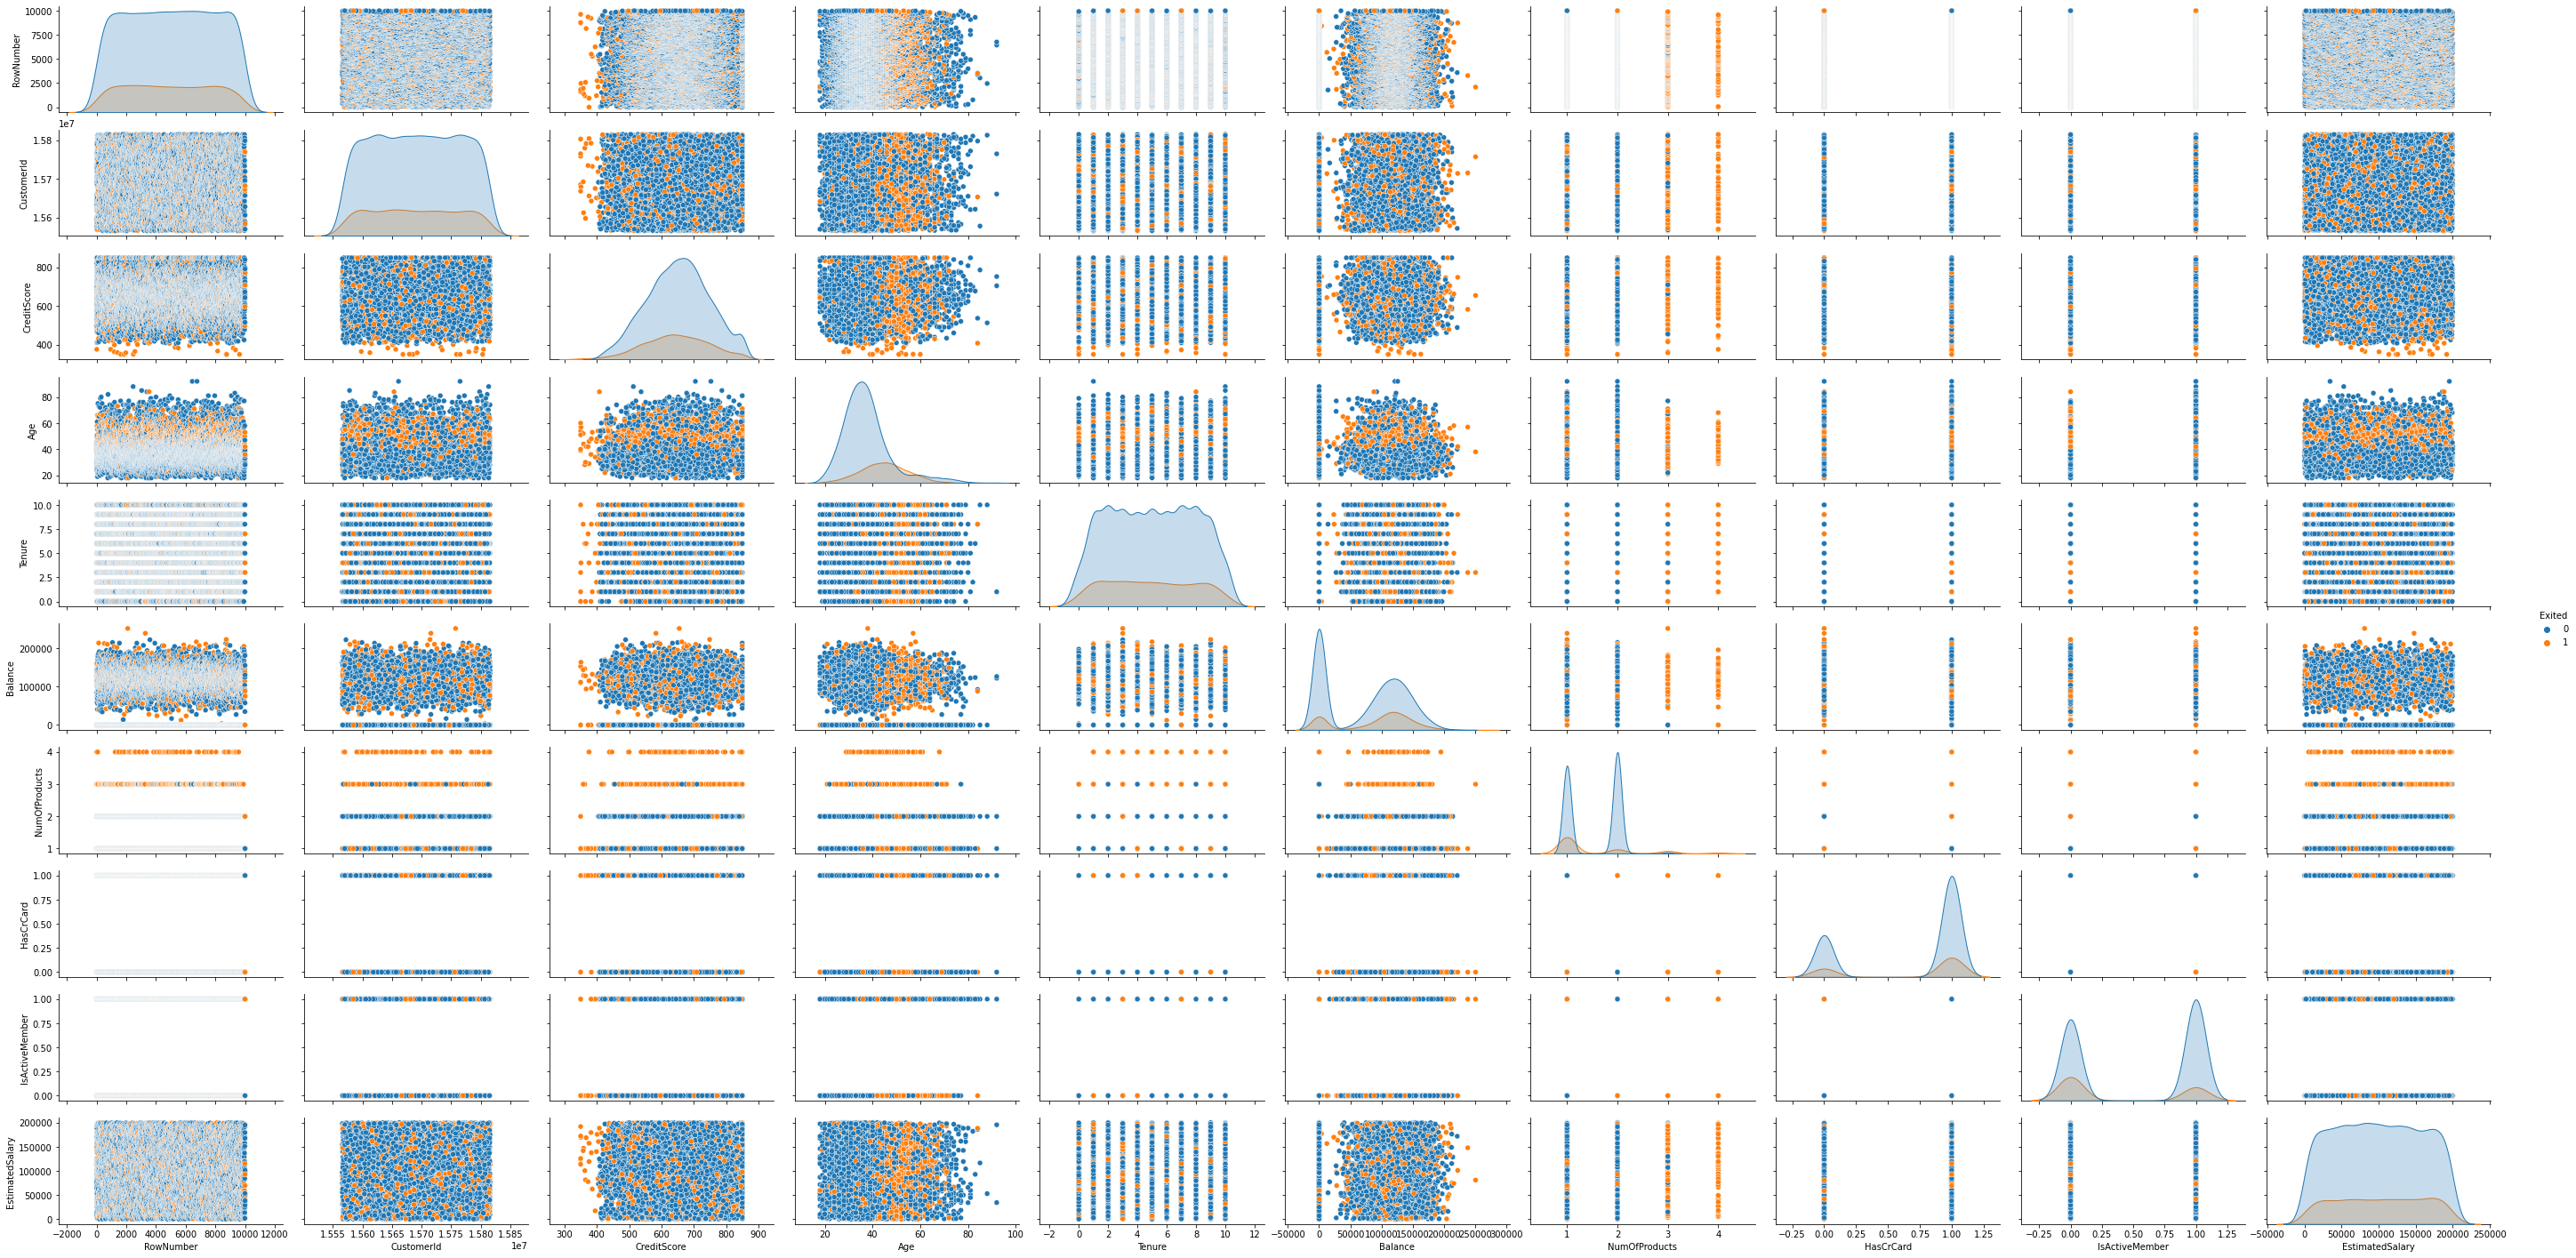

In [5]:
sns.pairplot(df, hue='Exited', height=2, aspect=2)

Хоть графики не самые лучшие, но можно увидеть что мультиколлинеарности нет. Также мы видим что наш файл с 10000 строками и 14 столбцами. В столбце Tenure имеются пропуски, нужно разобраться с их природой и посмотреть что сможем сделать для его заполнения. В файле разные типы данных, попробуем свести их к минимуму, если это потребуется. Разделим наш датасет на обучающую, валидационную и тестовую выборки для того, чтобы мы могли обучить нашу модель, проверить её как она обучилась и зафиналить всё контрольным тестом.

## Подготовим данные

### Посмотрим на столбец Tenure "сколько лет человек является клиентом банка"

In [10]:
df['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

Можем увидеть, что в столбце Tenure имеются пропуски. Это может указывать на ошибку при передаче данных, и пустые значения можно заполнить либо 0, либо медианой. Мы же заполним 0, потому что исодим из логики, что человек только недавно стал клиентом банка, и данные просто не успели заполнить.

In [11]:
df['Tenure'] = df['Tenure'].fillna(0)

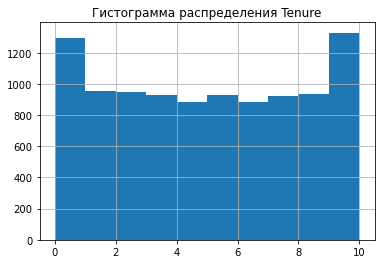

In [12]:
df['Tenure'].hist()
plt.title('Гистограмма распределения Tenure')
plt.show()

### Удалим столбец RowNumber "индекс строки в данных", т к он не является критически важным.

In [13]:
df = df.drop('RowNumber', axis=1)

In [3]:
df.head()

### Удалим столбец Surname "фамилия", т к он не является критически важным, потому что люди могли уйти из банка потому что, например, переехали, а не потому что они Смиты.

In [15]:
df = df.drop('Surname', axis=1)

In [4]:
df.head()

### Удалим столбец CustomerId  "уникальный идентификатор клиента", т к он не является критически важным. 

In [17]:
df = df.drop('CustomerId', axis=1)

In [5]:
df.head()

### Применим прямое кодирование ко всему датафрейму, т к у нас есть категориальные переменные

In [19]:
df = pd.get_dummies(df, drop_first=True)

## Разделим данные на обучающую и валидационную выборки. Выделим целевой признак в отдельную переменную

In [20]:
X, y = df.drop(columns=['Exited']), df['Exited']
X.shape, y.shape

((10000, 11), (10000,))

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.6, random_state = 22)

### Отделим от валидационной выборки тестовую

In [22]:
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, train_size = 0.5, random_state = 22)

### Проверим размеры полученных датасетов

In [19]:
print("Разрешение тренировочного датасета на входе:", X_train.shape)
print("Разрешение валидационного датасета на входе:", X_valid.shape)
print("Разрешение тестового датасета на входе:", X_test.shape)
print("Разрешение тренировочного датасета на выходе:", y_train.shape)
print("Разрешение валидационного датасета на выходе:", y_valid.shape)
print("Разрешение тестового датасета на выходе:", y_test.shape)

Разрешение тренировочного датасета на входе: (6000, 11)
Разрешение валидационного датасета на входе: (2000, 11)
Разрешение тестового датасета на входе: (2000, 11)
Разрешение тренировочного датасета на выходе: (6000,)
Разрешение валидационного датасета на выходе: (2000,)
Разрешение тестового датасета на выходе: (2000,)


### Займемся обучением тестовых моделей и выберем лучшую. 

#### Обучим модель "дерево решений", посмотрим на точность, полноту.  Построим матрицу ошибок

In [15]:
dt = DecisionTreeClassifier().fit(X_train, y_train)

In [16]:
dt_predicted_valid = dt.predict(X_valid)

In [17]:
confusion_matrix(y_valid, dt_predicted_valid)

array([[1431,  177],
       [ 216,  176]], dtype=int64)

In [23]:
print(classification_report(y_valid, dt_predicted_valid))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1608
           1       0.48      0.45      0.47       392

    accuracy                           0.80      2000
   macro avg       0.68      0.67      0.67      2000
weighted avg       0.79      0.80      0.80      2000



In [18]:
dt_probabilities_valid = dt.predict_proba(X_valid)
dt_probabilities_one_valid = dt_probabilities_valid[:, 1]

fpr1, tpr1, thresholds1 = roc_curve(y_valid, dt_probabilities_one_valid)

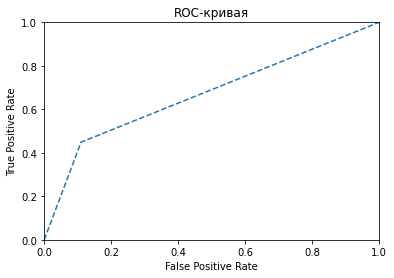

In [19]:
plt.figure()
plt.plot(fpr1, tpr1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [20]:
roc_auc_score(y_valid, dt_predicted_valid)

0.6694524824855316

Данная модель имеет значение roc_auc_score 0.66, но судя по графику, она будет очень сильно похожа на случайную модель

#### Обучим модель "случайный лес", посмотрим на точность, полноту.  Построим матрицу ошибок

In [27]:
rfc = RandomForestClassifier().fit(X_train, y_train)

In [28]:
rfc_predicted_valid = rfc.predict(X_valid)

In [29]:
confusion_matrix(y_valid, rfc_predicted_valid)

array([[1560,   48],
       [ 227,  165]])

In [30]:
print(classification_report(y_valid, rfc_predicted_valid))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1608
           1       0.77      0.42      0.55       392

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.73      2000
weighted avg       0.85      0.86      0.85      2000



In [31]:
rfc_probabilities_valid = rfc.predict_proba(X_valid)
rfc_probabilities_one_valid = rfc_probabilities_valid[:, 1]

fpr2, tpr2, thresholds2 = roc_curve(y_valid, rfc_probabilities_one_valid)

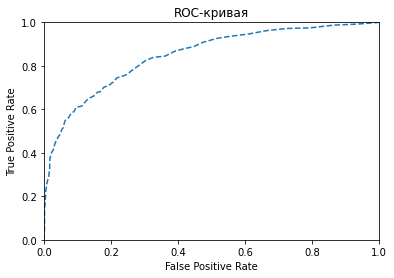

In [32]:
plt.figure()
plt.plot(fpr2, tpr2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [33]:
roc_auc_score(y_valid, rfc_predicted_valid)

0.6955338105391411

На данном графике видно, что получившаяся модель отличается от любой случайной. В подтверждение roc_auc_score = 0.69

#### Обучим модель " логической регрессии ", посмотрим на точность, полноту.  Построим матрицу ошибок

In [34]:
lg = LogisticRegression().fit(X_train, y_train)

In [35]:
lg_predicted_valid = lg.predict(X_valid)

In [36]:
confusion_matrix(y_valid, lg_predicted_valid)

array([[1575,   33],
       [ 369,   23]])

In [37]:
print(classification_report(y_valid, lg_predicted_valid))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      1608
           1       0.41      0.06      0.10       392

    accuracy                           0.80      2000
   macro avg       0.61      0.52      0.49      2000
weighted avg       0.73      0.80      0.73      2000



In [38]:
lg_probabilities_valid = lg.predict_proba(X_valid)
lg_probabilities_one_valid = lg_probabilities_valid[:, 1]

fpr3, tpr3, thresholds3 = roc_curve(y_valid, lg_probabilities_one_valid)

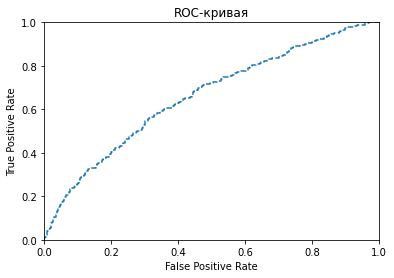

In [39]:
plt.figure()
plt.plot(fpr3, tpr3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [40]:
roc_auc_score(y_valid, lg_predicted_valid)

0.5190755406640267

На нашем графике видно, что данная модель близка к любой случайной модели, в подтверждение мы имеем roc_auc_score = 0.51, а у любой случайной модели значение 0.5.

Как мы можнем заметить из 3 моделей лучше всего показала себя модель метода "случайный лес". Мы имеем точность 0.86, полноту 0.41,  f1 мера - 0.54, но модель склонна к предсказаниям в пользу того, что клиент останется в банке, т к этих данных больше. Улучшим нашу модель, постараемся довести f1 меру выше 0.59.

### Улучшим качество модели "случайный лес" c помощью подбора гиперпараметров и балансировки классов. 

#### Посмотрим на наш обучающий признак

In [23]:
y.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Число положительных ответов ниже отрицательных примерно в 3.7 раза. Сбалансируем наши данные и сведем разницу к минимуму, затем посмотрим на результат. Создадим 3 модели и обучим их на разных данных: одну группу данных сбалансируем методом upsampling, другую - downsampling,

для этого напишем две функции:

- <span style="color:blue">первая</span> будет принимать на вход наши данные, делить их на положительные и отрицательные, затем копировать случайные положительные значенения несколько раз, мешать их и возвращать новые данные. 

- <span style="color:blue">вторая</span> будет принимать на вход данные, также делить на положительные и отрицательные, затем случайным образом отбрасывать отрицательные значения, мешать их и возвращать новые данные

В параметрах <span style="color:blue">третьей</span> модели добавим настройку class_weight='balanced', тем самым придав объектам редкого класса больший вес.

#### Создадим функцию upsampling

In [24]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(X_train, y_train, 4)

In [25]:
target_upsampled.value_counts()

1    4908
0    4773
Name: Exited, dtype: int64

Сбалансировали данные, посмотрим что будет с моделью

In [36]:
best_params = None
best_result = 0
best_f1 = 0

for params in tqdm(itertools.product(range(1, 16), range(1,21), range(1, 10))):
    depth, est, features = params
    model = RandomForestClassifier(random_state=22, 
                                   max_depth=depth, 
                                   n_estimators=est,
                                   max_features=features
                                   )
    model = model.fit(features_upsampled, target_upsampled)
    result = model.score(X_valid, y_valid) 
    predict = model.predict(X_valid)
    f1 = f1_score(y_valid, predict)
    if result > best_result:
        best_params = params
        best_f1 = f1
        best_result = result


best_model = RandomForestRegressor(random_state=22,
                                    max_depth=best_params[0], 
                                    n_estimators=best_params[1],
                                   max_features=best_params[2]).fit(features_upsampled, target_upsampled)
        
print(f'F1-мера наилучшей модели на валидационной выборке {np.round(best_f1, 5)}')
print(f'качество модели на валидационной выборке {np.round(best_result, 5)}')
print(f'\nParams:\nmax_depth = {best_params[0]}\nn_estimators = {best_params[1]}\nmax_features = {best_params[2]}')

2700it [04:10, 10.80it/s]

F1-мера наилучшей модели на валидационной выборке 0.60192
качество модели на валидационной выборке 0.8545

Params:
max_depth = 15
n_estimators = 16
max_features = 5


In [55]:
best_model.feature_importances_

array([0.11949907, 0.27881991, 0.06749109, 0.14836809, 0.13656302,
       0.01658545, 0.03849818, 0.13074043, 0.02912515, 0.01262806,
       0.02168155])

Здесь мы увеличивали наши положительные значения. И можно заметить, что теперь наша f1 мера равна требуемому значению.

#### Создадим функцию downsabpling

In [31]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=22)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=22)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=22)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(X_train, y_train, 0.3)

In [46]:
target_downsampled.value_counts()

0    1432
1    1227
Name: Exited, dtype: int64

Сбалансировали данные, посмотрим теперь на модель

In [35]:
best_params2 = None
best_result2 = 0
best_f1_2 = 0

for params2 in tqdm(itertools.product(range(1, 16), range(1,21), range(1, 10))):
    depth, est, features = params2
    model2 = RandomForestClassifier(random_state=22, 
                                    max_depth=depth, 
                                    n_estimators=est, 
                                    max_features=features)
    model2 = model2.fit(features_downsampled, target_downsampled)
    result2 = model2.score(X_valid, y_valid) 
    predict2 = model2.predict(X_valid)
    f1_2 = f1_score(y_valid, predict2) 
    if result2 > best_result2:
        best_params2 = params2
        best_f1_2 = f1_2
        best_result2 = result2
        
best_model_2 = RandomForestClassifier(random_state=22, 
                                      max_depth=best_params2[0], 
                                      n_estimators=best_params2[1], 
                                      max_features=best_params2[2]).fit(features_downsampled, target_downsampled)
       

print(f'F1-мера наилучшей модели на валидационной выборке {np.round(best_f1_2, 5)}')
print(f'качество модели на валидационной выборке {np.round(best_result2, 5)}')
print(f'\nParams:\nmax_depth = {best_params2[0]}\nn_estimators = {best_params2[1]}\nmax_features = {best_params2[2]}')

2700it [01:56, 23.24it/s]

F1-мера наилучшей модели на валидационной выборке 0.49835
качество модели на валидационной выборке 0.848

Params:
max_depth = 1
n_estimators = 7
max_features = 3


In [54]:
best_model_2.feature_importances_

array([0.14285714, 0.14285714, 0.        , 0.        , 0.14285714,
       0.        , 0.14285714, 0.        , 0.14285714, 0.14285714,
       0.14285714])

Здесь мы уменьшали наши отрицательные значения. Можно заметить, что данная модель имеет значение f1 меры гораздо ниже, чем тестовая модель.

#### Придадим объектам редкого класса больший вес через параметр class_weight

In [57]:
best_params3 = None
best_result3 = 0
best_f1_3 = 0

for params3 in tqdm(itertools.product(range(1, 16), range(1,21), range(1, 10))):
    depth, est, features = params3
    model3 = RandomForestClassifier(random_state=22, 
                                    max_depth=depth, 
                                    n_estimators=est, 
                                    max_features=features, 
                                    class_weight='balanced')
    model3 = model3.fit(X_train, y_train)
    result3 = model3.score(X_valid, y_valid) 
    predict3 = model3.predict(X_valid)    
    f1_3 = f1_score(y_valid, predict3)
    if result3 > best_result3:
        best_params3 = params3 
        best_f1_3 = f1_3
        best_result3 = result3
        
best_model_3 = RandomForestClassifier(random_state=22, 
                                      max_depth=best_params3[0], 
                                      n_estimators=best_params3[1], 
                                      max_features=best_params3[2],
                                      class_weight='balanced').fit(X_train, y_train)
        
print(f'F1-мера наилучшей модели на валидационной выборке {np.round(best_f1_3, 5)}')
print(f'качество модели на валидационной выборке {np.round(best_result3, 5)}')
print(f'\nParams:\nmax_depth = {best_params3[0]}\nn_estimators = {best_params3[1]}\nmax_features = {best_params3[2]}')

2700it [03:58, 11.33it/s]

F1-мера наилучшей модели на валидационной выборке 0.56693
качество модели на валидационной выборке 0.8625

Params:
max_depth = 15
n_estimators = 20
max_features = 5


In [58]:
best_model_3.feature_importances_

array([0.12083126, 0.27249664, 0.06809129, 0.1566639 , 0.13029229,
       0.01768179, 0.03823817, 0.13452816, 0.0267653 , 0.01318843,
       0.02122279])

Данная модель получилась чуть лучше, чем тестовая, но значение f1 меры не дотягивет до необходимого.

- нами были обучены 3 модели "случайного леса"
- для каждой модели данные для обучения подготавливались по-разному
- самое большое значение f1 меры получается для модели с применением метода upsampling для данных, что в принципе логично. Мы даём больше данных для обучения, модель лучше учится.
- для метода, придающего объектам редкого класса больший вес через параметр class_weight, значение f1 меры получается чуть выше чем у тестовой, но недостаточным для того, чтобы использовать её.
- для модели с методом downsampling значение f1 меры получается гораздо ниже требуемого, что в принипе тоже логично. Мы отнимаем часть данных, не добавляя новых, и наша модель ,неумеющая определять положительные значения, теряет способность определять отрицательные. 


## Проврим нашу лучшую модель на тестовой выборке

In [30]:
predict_final = best_model.predict(X_test)
np.round(f1_score(y_test, predict_final), 4)

0.6144

In [31]:
print(classification_report(y_test, predict_final))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1582
           1       0.63      0.60      0.61       418

    accuracy                           0.84      2000
   macro avg       0.76      0.75      0.76      2000
weighted avg       0.84      0.84      0.84      2000



### Соеденим валидационную и тестовую выборки. Посмотрим что будет с метрикой

In [32]:
X_full = pd.concat([X_valid, X_test], ignore_index=True)
y_full = pd.concat([y_valid, y_test], ignore_index=True)

In [33]:
predict_full_final = best_model.predict(X_full)
np.round(f1_score(y_full, predict_full_final), 4)

0.6085

In [34]:
print(classification_report(y_full, predict_full_final))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      3190
           1       0.64      0.58      0.61       810

    accuracy                           0.85      4000
   macro avg       0.77      0.75      0.76      4000
weighted avg       0.84      0.85      0.85      4000



In [37]:
probabilities_valid = best_model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr3, tpr3, thresholds3 = roc_curve(y_valid, probabilities_one_valid)

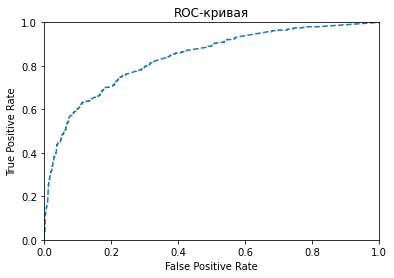

In [38]:
plt.figure()
plt.plot(fpr3, tpr3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Нам удалось получить значение метрики f1 меры выше 0.59 в обоих случаях при проверке на тестовых выборках, что говорит нам о том, что наша модель способна к выполнению поставленной ей задачи.